<a href="https://colab.research.google.com/github/learning-toolz/ml/blob/main/jhu_week_7_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                  feedback     label
0       I love this product, it's amazing!  positive
1       This is the worst experience ever.  negative
2  Absolutely fantastic! Highly recommend.  positive
3          Not good, really disappointing.  negative
4          I am extremely happy with this.  positive


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


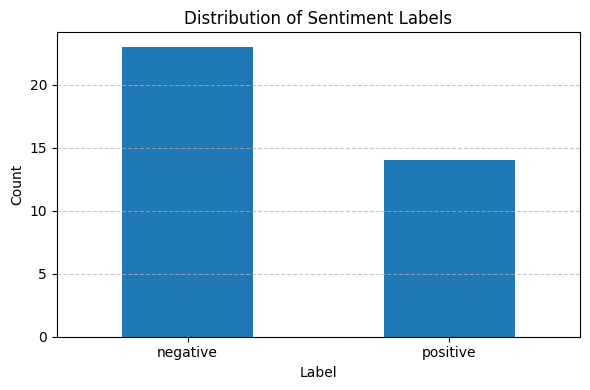

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Sample preprocessed feedback:
                                  feedback  \
0       I love this product, it's amazing!   
1       This is the worst experience ever.   
2  Absolutely fantastic! Highly recommend.   
3          Not good, really disappointing.   
4          I am extremely happy with this.   

                        cleaned_feedback  
0                   love product amazing  
1                  worst experience ever  
2  absolutely fantastic highly recommend  
3              good really disappointing  
4                        extremely happy  

Classification Report:
              precision    recall  f1-score   support

    negative       0.62      1.00      0.77         5
    positive       0.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8

Accuracy: 0.625

Cross-validated accuracy (5-fold):
[0.625      0.625      0.571428

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import logging
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment import SentimentIntensityAnalyzer

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Download required resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

def load_feedback_custom_format(file_path):
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, start=1):
                try:
                    line = line.strip().rstrip(',')           # Remove trailing comma
                    line = line.strip('()')                   # Remove parentheses
                    reader = csv.reader([line], quotechar='"', delimiter=',', skipinitialspace=True)
                    for row in reader:
                        if len(row) == 2:
                            feedback, label = row
                            data.append((feedback, label))
                        else:
                            logging.warning(f"Line {line_num} skipped due to unexpected format: {line}")
                except Exception as e:
                    logging.error(f"Error parsing line {line_num}: {e}")

        df = pd.DataFrame(data, columns=['feedback', 'label'])
        logging.info(f"Loaded {len(df)} feedback entries.")
        print(df.head())
        return df
    except FileNotFoundError:
        logging.error(f"File not found: {file_path}")
    except Exception as e:
        logging.error(f"An error occurred while reading the file: {e}")
    return pd.DataFrame(columns=['feedback', 'label'])

def plot_label_distribution(df):
    label_counts = df['label'].value_counts()

    plt.figure(figsize=(6, 4))
    label_counts.plot(kind='bar')
    plt.title('Distribution of Sentiment Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def preprocess_feedback(text):
    # Lowercasing: Converts all characters to lowercase to standardize text and reduce sparsity.
    text = text.lower()

    # Punctuation removal: Removes symbols like !, ?, . that may not carry sentiment.
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenization: Splits text into words for easier processing.
    tokens = word_tokenize(text)

    # Stopword removal: Eliminates common words like "the", "is", etc., which do not add semantic value.
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming: Reduces words to their base/root form (e.g., running -> run).
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization: Converts words to dictionary form (e.g., better -> good), using context.
    # lemmatizer = WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

def train_and_evaluate_model(X, y, model=None):
    if model is None:
        model = LogisticRegression(class_weight='balanced', max_iter=1000)

    # Split the dataset first
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit on training data only, transform both train and test
    vectorizer = CountVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Cross-validation on full dataset (vectorized independently)
    full_vec = vectorizer.fit_transform(X)
    print("\nCross-validated accuracy (5-fold):")
    scores = cross_val_score(model, full_vec, y, cv=5, scoring='accuracy')
    print(scores)
    print("Mean Accuracy:", scores.mean())

def analyze_sentiment_with_vader(df):
    sia = SentimentIntensityAnalyzer()
    def get_sentiment(text):
        score = sia.polarity_scores(text)['compound']
        return 'positive' if score >= 0 else 'negative'
    df['vader_sentiment'] = df['feedback'].apply(get_sentiment)
    print("\nVADER Sentiment Analysis Sample:")
    print(df[['feedback', 'vader_sentiment']].head())

    # Evaluate VADER sentiment predictions
    accuracy = accuracy_score(df['label'], df['vader_sentiment'])
    print("\nVADER Accuracy:", accuracy)
    print("VADER Classification Report:")
    print(classification_report(df['label'], df['vader_sentiment']))

# main program
if __name__ == '__main__':
    # Load the file
    FILE_PATH = 'sample_data/jhu_week7_feedback.txt'
    df_feedback = load_feedback_custom_format(FILE_PATH)
    # Visualize the data
    plot_label_distribution(df_feedback)

    # Apply preprocessing to feedback text
    df_feedback['cleaned_feedback'] = df_feedback['feedback'].apply(preprocess_feedback)
    print("\nSample preprocessed feedback:")
    print(df_feedback[['feedback', 'cleaned_feedback']].head())

    # Train and evaluate model with default SVC
    train_and_evaluate_model(df_feedback['cleaned_feedback'], df_feedback['label'], model = SVC(kernel='rbf', random_state=42))
    train_and_evaluate_model(df_feedback['cleaned_feedback'], df_feedback['label'], model = RandomForestClassifier(n_estimators=10, random_state=42))

    # Using NLP
    analyze_sentiment_with_vader(df_feedback)


